#Library to practice: 
https://github.com/pgmpy/pgmpy

In [ ]:
!conda install -c ankurankan pgmpy

  **Parameter learning**: Given a set of data samples and a DAG that captures the dependencies between the variables, estimate the (conditional) probability distributions of the individual variables.

  **Structure learning**: Given a set of data samples, estimate a DAG that captures the dependencies between the variables.

  This notebook aims to illustrate how parameter learning and structure learning can be done with pgmpy. Currently, the library supports:
  

Parameter learning for discrete nodes:

*   Maximum Likelihood Estimation
*   Bayesian Estimation
    
Structure learning for discrete, fully observed networks:
    
*    Score-based structure estimation (BIC/BDeu/K2 score; exhaustive search, hill climb/tabu search)
*   Constraint-based structure estimation (PC)
*   Hybrid structure estimation (MMHC)


# **Parameter Learning **

  Suppose we have the following data:

In [51]:
import pandas as pd
data = pd.DataFrame(data={'fruit': ["banana", "apple", "banana", "apple", "banana","apple", "banana", 
                                    "apple", "apple", "apple", "banana", "banana", "apple", "banana",], 
                          'tasty': ["yes", "no", "yes", "yes", "yes", "yes", "yes", 
                                    "yes", "yes", "yes", "yes", "no", "no", "no"], 
                          'size': ["large", "large", "large", "small", "large", "large", "large",
                                    "small", "large", "large", "large", "large", "small", "small"]})
print(data)

     fruit tasty   size
0   banana   yes  large
1    apple    no  large
2   banana   yes  large
3    apple   yes  small
4   banana   yes  large
5    apple   yes  large
6   banana   yes  large
7    apple   yes  small
8    apple   yes  large
9    apple   yes  large
10  banana   yes  large
11  banana    no  large
12   apple    no  small
13  banana    no  small


In [52]:
from pgmpy.models import BayesianNetwork

model = BayesianNetwork([('fruit', 'tasty'), ('size', 'tasty')])  # fruit -> tasty <- size

State counts
To make sense of the given data, we can start by counting how often each state of the variable occurs. If the variable is dependent on parents, the counts are done conditionally on the parents states, i.e. for seperately for each parent configuration:

In [54]:
from pgmpy.estimators import ParameterEstimator
pe = ParameterEstimator(model, data)
print("\n", pe.state_counts('fruit'))  # unconditional
print("\n", pe.state_counts('tasty'))
print("\n", pe.state_counts('size')) 
  # conditional on fruit and size


         count
fruit        
apple       7
banana      7

 fruit apple       banana      
size  large small  large small
tasty                         
no      1.0   1.0    1.0   1.0
yes     3.0   2.0    5.0   0.0

        count
size        
large     10
small      4


In [6]:
from pgmpy.estimators import MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(model, data)
print(mle.estimate_cpd('fruit'))  # unconditional

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+


In [46]:
print(mle.estimate_cpd('size')) 

+-------------+----------+
| size(large) | 0.714286 |
+-------------+----------+
| size(small) | 0.285714 |
+-------------+----------+


In [55]:
conditional = mle.estimate_cpd('tasty')
print(conditional.to_csv(filename="conditional_tasty.csv"))  # conditional on fruit and size

None


In [7]:
print(mle.estimate_cpd('tasty'))  # conditional

+------------+--------------+-----+---------------+
| fruit      | fruit(apple) | ... | fruit(banana) |
+------------+--------------+-----+---------------+
| size       | size(large)  | ... | size(small)   |
+------------+--------------+-----+---------------+
| tasty(no)  | 0.25         | ... | 1.0           |
+------------+--------------+-----+---------------+
| tasty(yes) | 0.75         | ... | 0.0           |
+------------+--------------+-----+---------------+


# **Maximum Likelihood Estimation**


A natural estimate for the CPDs is to simply use the relative frequencies, with which the variable states have occured. We observed 7 apples among a total of 14 fruits, so we might guess that about 50% of fruits are apples.

This approach is Maximum Likelihood Estimation (MLE). According to MLE, we should fill the CPDs in such a way, that $P(\text{data}|\text{model})$ is maximal. This is achieved when using the relative frequencies. See [1], section 17.1 for an introduction to ML parameter estimation. pgmpy supports MLE as follows:

In [13]:
from pgmpy.estimators import MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(model, data)
print(mle.estimate_cpd('fruit'))  # unconditional
print(mle.estimate_cpd('tasty'))  # conditional

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+------------+--------------+-----+---------------+
| fruit      | fruit(apple) | ... | fruit(banana) |
+------------+--------------+-----+---------------+
| size       | size(large)  | ... | size(small)   |
+------------+--------------+-----+---------------+
| tasty(no)  | 0.25         | ... | 1.0           |
+------------+--------------+-----+---------------+
| tasty(yes) | 0.75         | ... | 0.0           |
+------------+--------------+-----+---------------+


mle.estimate_cpd(variable) computes the state counts and divides each cell by the (conditional) sample size. The mle.get_parameters()-method returns a list of CPDs for all variable of the model.

The built-in fit()-method of BayesianModel provides more convenient access to parameter estimators:

In [57]:
# Calibrate all CPDs of `model` using MLE:
model.fit(data, estimator=MaximumLikelihoodEstimator)

INFO:numexpr.utils:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [58]:
print(model.get_cpds("tasty"))

+------------+--------------+-----+---------------+
| fruit      | fruit(apple) | ... | fruit(banana) |
+------------+--------------+-----+---------------+
| size       | size(large)  | ... | size(small)   |
+------------+--------------+-----+---------------+
| tasty(no)  | 0.25         | ... | 1.0           |
+------------+--------------+-----+---------------+
| tasty(yes) | 0.75         | ... | 0.0           |
+------------+--------------+-----+---------------+


In [59]:
model.get_cpds("tasty").to_csv("tastycpd.csv")

In [16]:
print(mle.estimate_cpd('tasty'))

+------------+--------------+-----+---------------+
| fruit      | fruit(apple) | ... | fruit(banana) |
+------------+--------------+-----+---------------+
| size       | size(large)  | ... | size(small)   |
+------------+--------------+-----+---------------+
| tasty(no)  | 0.25         | ... | 1.0           |
+------------+--------------+-----+---------------+
| tasty(yes) | 0.75         | ... | 0.0           |
+------------+--------------+-----+---------------+



While very straightforward, the ML estimator has the problem of overfitting to the data. In above CPD, the probability of a large banana being tasty is estimated at 0.833, because 5 out of 6 observed large bananas were tasty. Fine. But note that the probability of a small banana being tasty is estimated at 0.0, because we observed only one small banana and it happened to be not tasty. But that should hardly make us certain that small bananas aren't tasty! We simply do not have enough observations to rely on the observed frequencies. If the observed data is not representative for the underlying distribution, ML estimations will be extremly far off.

When estimating parameters for Bayesian networks, lack of data is a frequent problem. Even if the total sample size is very large, the fact that state counts are done conditionally for each parents configuration causes immense fragmentation. If a variable has 3 parents that can each take 10 states, then state counts will be done seperately for 10^3 = 1000 parents configurations. This makes MLE very fragile and unstable for learning Bayesian Network parameters. A way to mitigate MLE's overfitting is Bayesian Parameter Estimation.

**Bayesian Parameter Estimation**


The Bayesian Parameter Estimator starts with already existing prior CPDs, that express our beliefs about the variables before the data was observed. Those "priors" are then updated, using the state counts from the observed data. See [1], Section 17.3 for a general introduction to Bayesian estimators.

One can think of the priors as consisting in pseudo state counts, that are added to the actual counts before normalization. Unless one wants to encode specific beliefs about the distributions of the variables, one commonly chooses uniform priors, i.e. ones that deem all states equiprobable.

A very simple prior is the so-called K2 prior, which simply adds 1 to the count of every single state. A somewhat more sensible choice of prior is BDeu (Bayesian Dirichlet equivalent uniform prior). For BDeu we need to specify an equivalent sample size N and then the pseudo-counts are the equivalent of having observed N uniform samples of each variable (and each parent configuration). In pgmpy:

**Bayesian Parameter Estimation**


The Bayesian Parameter Estimator starts with already existing prior CPDs, that express our beliefs about the variables before the data was observed. Those "priors" are then updated, using the state counts from the observed data. 

One can think of the priors as consisting in pseudo state counts, that are added to the actual counts before normalization. Unless one wants to encode specific beliefs about the distributions of the variables, one commonly chooses uniform priors, i.e. ones that deem all states equiprobable.

A very simple prior is the so-called K2 prior, which simply adds 1 to the count of every single state. A somewhat more sensible choice of prior is BDeu (Bayesian Dirichlet equivalent uniform prior). For BDeu we need to specify an equivalent sample size N and then the pseudo-counts are the equivalent of having observed N uniform samples of each variable (and each parent configuration). In pgmpy:

In [22]:
from pgmpy.estimators import BayesianEstimator
est = BayesianEstimator(model, data)

print(est.estimate_cpd('tasty', prior_type='BDeu', equivalent_sample_size=10))

+------------+---------------------+-----+---------------------+
| fruit      | fruit(apple)        | ... | fruit(banana)       |
+------------+---------------------+-----+---------------------+
| size       | size(large)         | ... | size(small)         |
+------------+---------------------+-----+---------------------+
| tasty(no)  | 0.34615384615384615 | ... | 0.6428571428571429  |
+------------+---------------------+-----+---------------------+
| tasty(yes) | 0.6538461538461539  | ... | 0.35714285714285715 |
+------------+---------------------+-----+---------------------+


In [23]:
est.estimate_cpd('tasty', prior_type='BDeu', equivalent_sample_size=10).to_csv(filename="tastyv2.csv")

In [25]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator

# generate data
data = pd.DataFrame(np.random.randint(low=0, high=2, size=(5000, 4)), columns=['A', 'B', 'C', 'D'])
model = BayesianNetwork([('A', 'B'), ('A', 'C'), ('D', 'C'), ('B', 'D')])

model.fit(data, estimator=BayesianEstimator, prior_type="BDeu") # default equivalent_sample_size=5
for cpd in model.get_cpds():
    print(cpd)

INFO:numexpr.utils:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


+------+----------+
| A(0) | 0.494406 |
+------+----------+
| A(1) | 0.505594 |
+------+----------+
+------+---------------------+------+
| A    | A(0)                | A(1) |
+------+---------------------+------+
| B(0) | 0.5040412204485755  | 0.5  |
+------+---------------------+------+
| B(1) | 0.49595877955142453 | 0.5  |
+------+---------------------+------+
+------+--------------------+-----+--------------------+
| A    | A(0)               | ... | A(1)               |
+------+--------------------+-----+--------------------+
| D    | D(0)               | ... | D(1)               |
+------+--------------------+-----+--------------------+
| C(0) | 0.5238239450837876 | ... | 0.5124878048780488 |
+------+--------------------+-----+--------------------+
| C(1) | 0.4761760549162124 | ... | 0.4875121951219512 |
+------+--------------------+-----+--------------------+
+------+---------------------+---------------------+
| B    | B(0)                | B(1)                |
+------+-------

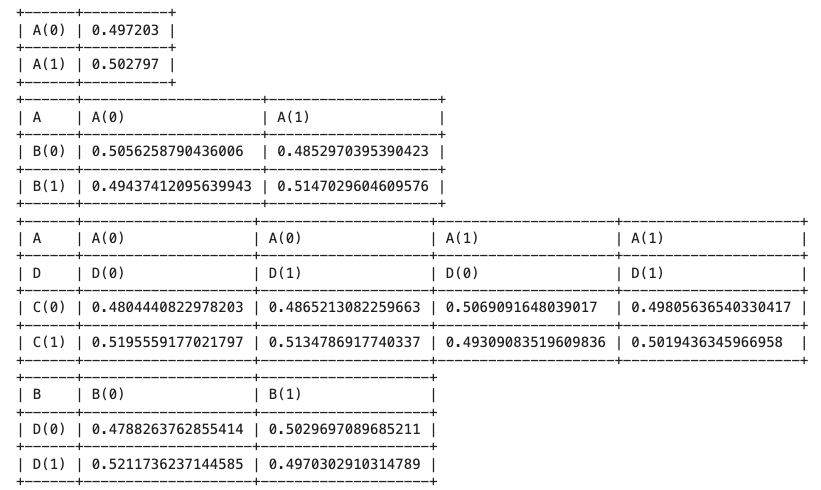

In [26]:
data

,A,B,C,D
0,0,0,1,1
1,1,0,1,0
2,1,1,1,0
3,1,1,0,1
4,0,1,0,0
...,...,...,...,...
4995,0,1,0,1
4996,0,1,0,1
4997,0,0,1,0
4998,0,1,1,1


# **Structure Learning**




To learn model structure (a DAG) from a data set, there are two broad techniques:

*   score-based structure learning
*   constraint-based structure learning

The combination of both techniques allows further improvement:

*   hybrid structure learning


We briefly discuss all approaches and give examples.

# **Score-based Structure Learning**


This approach construes model selection as an optimization task. It has two building blocks:

A scoring function $s_D\colon M \to \mathbb R$ that maps models to a numerical score, based on how well they fit to a given data set $D$.
A search strategy to traverse the search space of possible models $M$ and select a model with optimal score.


**Scoring functions**


Commonly used scores to measure the fit between model and data are Bayesian Dirichlet scores such as BDeu or K2 and the Bayesian Information Criterion (BIC, also called MDL) As before, BDeu is dependent on an equivalent sample size.

In [29]:
import pandas as pd
import numpy as np
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianNetwork

# create random data sample with 3 variables, where Z is dependent on X, Y:
data = pd.DataFrame(np.random.randint(0, 4, size=(5000, 2)), columns=list('XY'))
data['Z'] = data['X'] + data['Y']

bdeu = BDeuScore(data, equivalent_sample_size=5)
k2 = K2Score(data)
bic = BicScore(data)

model1 = BayesianNetwork([('X', 'Z'), ('Y', 'Z')])  # X -> Z <- Y
model2 = BayesianNetwork([('X', 'Z'), ('X', 'Y')])  # Y <- X -> Z


print(bdeu.score(model1))
print(k2.score(model1))
print(bic.score(model1))

print(bdeu.score(model2))
print(k2.score(model2))
print(bic.score(model2))

-13938.892286978487
-14329.779969890547
-14294.927816228603
-20910.860204083026
-20937.681103339415
-20954.89641557016


While the scores vary slightly, we can see that the correct model1 has a much higher score than model2. Importantly, these scores decompose, i.e. they can be computed locally for each of the variables given their potential parents, independent of other parts of the network:


**Search strategies**


The search space of DAGs is super-exponential in the number of variables and the above scoring functions allow for local maxima. The first property makes exhaustive search intractable for all but very small networks, the second prohibits efficient local optimization algorithms to always find the optimal structure. Thus, identifiying the ideal structure is often not tractable. Despite these bad news, heuristic search strategies often yields good results.

If only few nodes are involved (read: less than 5), ExhaustiveSearch can be used to compute the score for every DAG and returns the best-scoring one:

In [30]:
from pgmpy.estimators import ExhaustiveSearch

es = ExhaustiveSearch(data, scoring_method=bic)
best_model = es.estimate()
print(best_model.edges())

print("\nAll DAGs by score:")
for score, dag in reversed(es.all_scores()):
    print(score, dag.edges())

[('X', 'Z'), ('Y', 'Z')]

All DAGs by score:
-14294.927816228603 [('X', 'Z'), ('Y', 'Z')]
-14332.701150973979 [('Y', 'X'), ('Z', 'X'), ('Z', 'Y')]
-14332.701150973979 [('Y', 'Z'), ('Y', 'X'), ('Z', 'X')]
-14332.701150973979 [('X', 'Z'), ('Y', 'Z'), ('Y', 'X')]
-14332.701150973979 [('X', 'Y'), ('Z', 'X'), ('Z', 'Y')]
-14332.701150973979 [('X', 'Y'), ('X', 'Z'), ('Z', 'Y')]
-14332.701150973979 [('X', 'Y'), ('X', 'Z'), ('Y', 'Z')]
-16530.50138753027 [('Y', 'X'), ('Z', 'X')]
-16532.315842790307 [('X', 'Y'), ('Z', 'Y')]
-18719.3228442685 [('Z', 'X'), ('Z', 'Y')]
-18719.3228442685 [('Y', 'Z'), ('Z', 'X')]
-18719.3228442685 [('X', 'Z'), ('Z', 'Y')]
-20917.123080824786 [('X', 'Z')]
-20917.12308082479 [('Z', 'X')]
-20918.937536084828 [('Z', 'Y')]
-20918.937536084828 [('Y', 'Z')]
-20954.896415570165 [('X', 'Z'), ('Y', 'X')]
-20954.896415570165 [('X', 'Y'), ('Z', 'X')]
-20954.896415570165 [('X', 'Y'), ('X', 'Z')]
-20956.710870830204 [('Y', 'X'), ('Z', 'Y')]
-20956.710870830204 [('Y', 'Z'), ('Y', 

Once more nodes are involved, one needs to switch to heuristic search. HillClimbSearch implements a greedy local search that starts from the DAG start (default: disconnected DAG) and proceeds by iteratively performing single-edge manipulations that maximally increase the score. The search terminates once a local maximum is found.

In [32]:
from pgmpy.estimators import HillClimbSearch

# create some data with dependencies
data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']

hc = HillClimbSearch(data)
best_model = hc.estimate()
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('A', 'B'), ('A', 'C'), ('A', 'G'), ('B', 'C'), ('H', 'A'), ('H', 'G')]



[('A', 'B'), ('A', 'C'), ('A', 'G'), ('B', 'C'), ('H', 'A'), ('H', 'G')]


The search correctly identifies e.g. that B and C do not influnce H directly, only through A and of course that D, E, F are independent.



To enforce a wider exploration of the search space, the search can be enhanced with a tabu list. The list keeps track of the last n modfications; those are then not allowed to be reversed, regardless of the score. Additionally a white_list or black_list can be supplied to restrict the search to a particular subset or to exclude certain edges. The parameter max_ind

**Constraint-based Structure Learning**

A different, but quite straightforward approach to build a DAG from data is this:

  1.Identify independencies in the data set using hypothesis tests
  
  2.Construct DAG (pattern) according to identified independencies

**(Conditional) Independence Tests**

Independencies in the data can be identified using chi2 conditional independence tests. To this end, constraint-based estimators in pgmpy have a test_conditional_independence(X, Y, Zs)-method, that performs a hypothesis test on the data sample. It allows to check if X is independent from Y given a set of variables Zs:

In [45]:
from pgmpy.estimators import PC
from pgmpy.estimators.CITests import chi_square

data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

est = PC(data)
print(chi_square(X='A', Y='B', Z=['C'],data=data,significance_level=0.05))  # X and Y independent given Zs

False
